In [79]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [80]:
sonar = pd.read_csv('sonar.all-data.csv', header=None, sep=',')
sonar1 = sonar.iloc[0:208,0:60]
sonar2 = np.array(sonar1)
y1 = np.zeros(104)
y2 = np.ones(104)
y = np.append(y1, y2)

In [81]:
def KNN(k, X_tr, y_tr, X_te, y_te, distance_type):
    """
    K最近邻分类器函数
    
    参数:
    k (int): 最近邻数目
    X_tr (numpy.ndarray): 训练集特征矩阵
    y_tr (numpy.ndarray): 训练集标签数组
    X_te (numpy.ndarray): 测试集特征矩阵
    y_te (numpy.ndarray): 测试集标签数组
    distance_type (str): 距离度量类型，如 'euclidean', 'manhattan' 等
    
    返回:
    accuracy (float): 分类器在测试集上的准确率
    """
    
    accuracy = 0  # 初始化准确率
    
    for i in range(X_te.shape[0]):  # 遍历测试集中的每个样本
        distance = np.zeros((2, X_tr.shape[0]))  # 创建一个二维数组，用于存储距离和对应的标签
        clas = np.zeros(2)  # 创建一个数组，用于统计最近邻中不同类别的数量
        
        for j in range(X_tr.shape[0]):  # 遍历训练集中的每个样本
            # 计算测试样本与训练样本之间的距离
            distance[1, j] = np.linalg.norm(X_te[i] - X_tr[j], ord=distance_type)
            distance[0, j] = y_tr[j]  # 存储对应的训练样本的标签
            
        index = np.lexsort(distance)  # 使用lexsort进行多级排序，返回排序后的索引
        
        for l in range(k):  # 获取最近的k个样本
            clas[int(distance[0, index[l]])] += 1  # 统计各类别的数量
        
        prediction = clas.argmax()  # 找出数量最多的类别，作为预测结果
        #若有类别投票结果相同，那么根据argmax函数方法，返回第一个作为结果
        if prediction == y_te[i]:  # 如果预测结果与真实标签一致
            accuracy += 1  # 增加准确率计数
        
    accuracy = accuracy / X_te.shape[0]  # 计算准确率，即正确预测的样本数除以总样本数
    return accuracy  # 返回准确率

In [82]:
accuracy_all = np.zeros((4,20))

In [83]:
def KNN_sonar(k, y, sonar2, distace_type):
        acc = 0
        for i in range(208):
                X_te = sonar2[i].reshape((1,60))
                X_tr = np.delete(sonar2, i, axis=0)
                y_te = y[i].reshape(1)
                y_tr = np.delete(y, i, axis=0)
                acc += KNN(k, X_tr, y_tr, X_te, y_te, distace_type)
        return acc/208

In [84]:
for m in tqdm(range(20)):
        k = m + 1
        #1为一范数2为二范数，inf为无穷范数，即吗，曼哈顿距离，欧氏距离，绝对值最大
        accuracy_all[0][m] = KNN_sonar(k, y, sonar2, 1)
        accuracy_all[1][m] = KNN_sonar(k, y, sonar2, 2)
        accuracy_all[2][m] = KNN_sonar(k, y, sonar2, np.inf)
        pass

100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


In [86]:
def Fisher(X1, X2, n):  #Fisher线性判别过程
    X1 = X1[:, 0:n]
    X2 = X2[:, 0:n]
    m1 = (np.mean(X1, axis=0))
    m2 = (np.mean(X2, axis=0))
    m1 = m1.reshape(n, 1)  # 将行向量转换为列向量以便于计算
    m2 = m2.reshape(n, 1)

    # 计算类内离散度矩阵
    S1 = np.zeros((n, n))
    S2 = np.zeros((n, n))
    for i in range(0, X1.shape[0]):
        S1 += (X1[i].reshape(n, 1) - m1).dot((X1[i].reshape(n, 1) - m1).T)
    for i in range(0, X2.shape[0]):
        S2 += (X2[i].reshape(n, 1) - m2).dot((X2[i].reshape(n, 1) - m2).T)
    # 计算总类内离散度矩阵S_w
    S_w = S1 + S2

    # 计算最优投影方向 W
    W = np.linalg.inv(S_w).dot(m1 - m2)
    # 在投影后的一维空间求两类的均值
    m_1 = (W.T).dot(m1)
    m_2 = (W.T).dot(m2)

    # 计算分类阈值 W0(为一个列向量)
    W0 = 0.5 * (m_1 + m_2)

    return W, W0


def Classify(X, W, W0, n):
    y = (W.T).dot(X[0:n, :]) - W0
    return y


P1 = sonar2[0:104, 0:60]
P2 = sonar2[104:208, 0:60]

result = np.zeros(208)
Accuracy = np.zeros(60)

for n in range(1, 61):
    count = 0
    for i in range(208):
        if i <= 103:
            test = P1[i]
            test = test.reshape(60, 1)
            train = np.delete(P1, i, axis=0)
            W,W0 = Fisher(train, P2, n)
            if (Classify(test, W, W0, n)) >= 0:
                count += 1
                result[i] = Classify(test, W, W0, n)
        else:
            test = P2[i-104]
            test = test.reshape(60, 1)
            train = np.delete(P2, i-104, axis=0)
            W,W0 = Fisher(P1, train, n)
            if (Classify(test, W, W0, n)) < 0:
                count += 1
                result[i] = Classify(test, W, W0, n)
    Accuracy[n-1] = count/208
    #print("分类准确率在维数取%d时为:%.3f" % (n, Accuracy[n-1]))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27416\3593287531.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result[i] = Classify(test, W, W0, n)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27416\3593287531.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result[i] = Classify(test, W, W0, n)


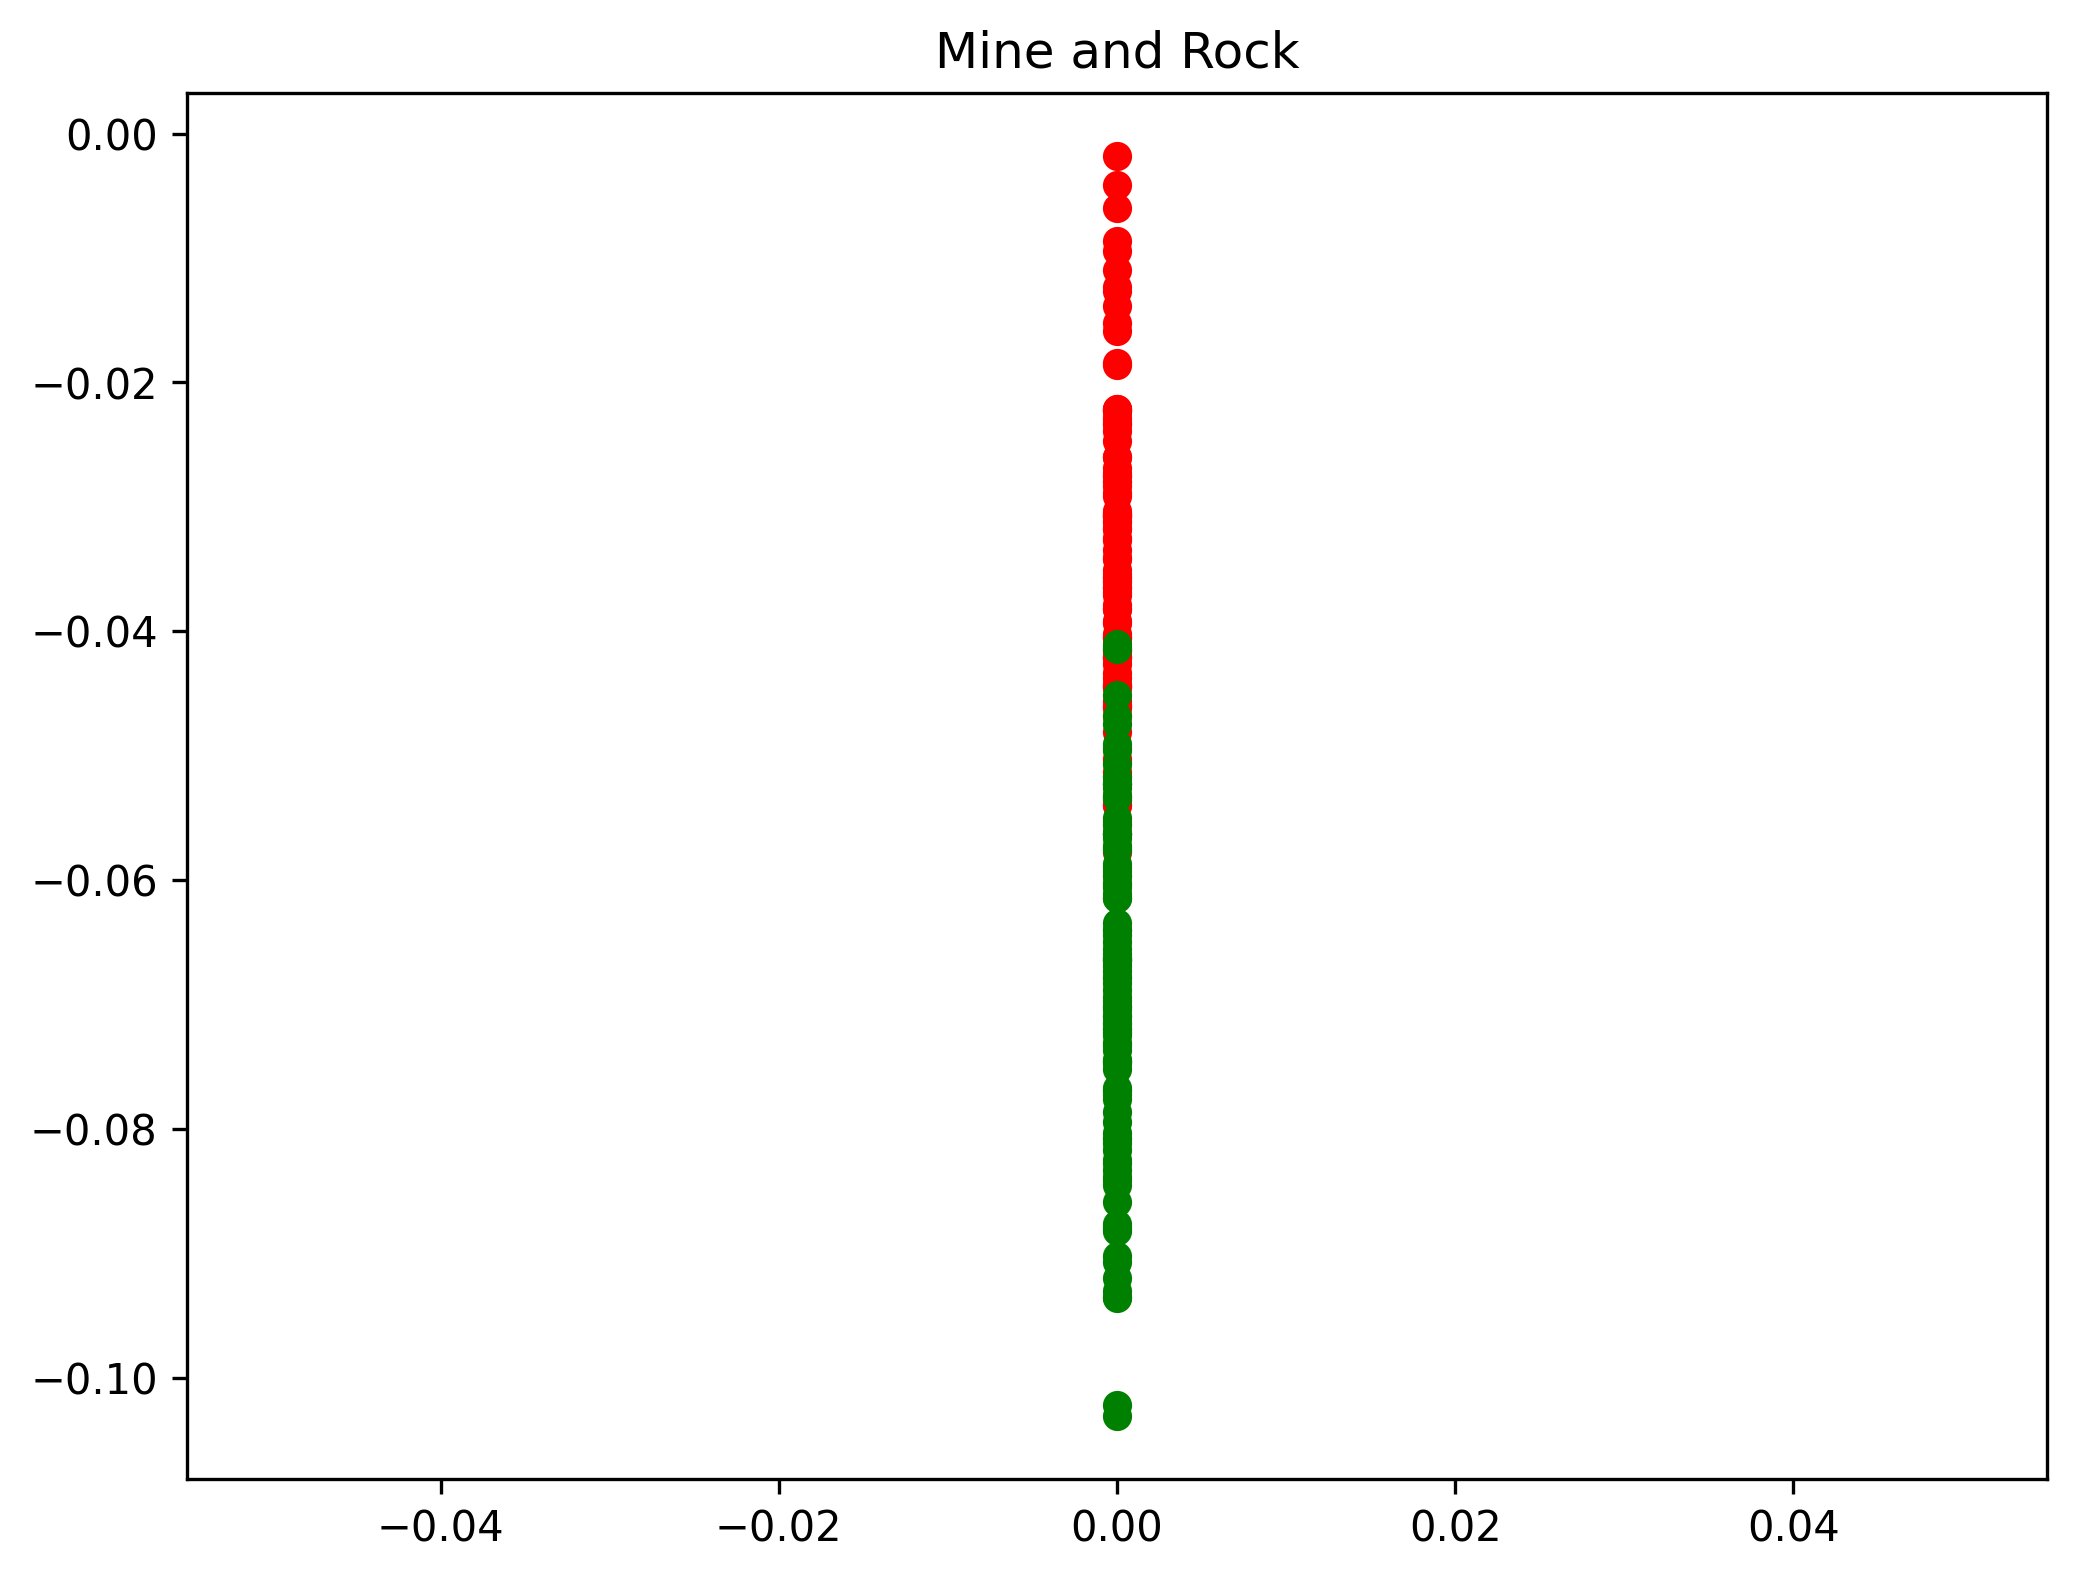

In [92]:
#class1 and class2
answer1=P1.dot(W)
answer2=P2.dot(W)
plt.figure(figsize=(8, 6), dpi=300)  # 调整图形大小和分辨率
plt.title( "Mine and Rock")
plt.plot(answer1.T,'r-o')
plt.plot(answer2.T,'g-o')
plt.savefig('Fisher_Sonar')
plt.show()

In [87]:
sonar2.shape,W.shape

((208, 60), (60, 1))

In [88]:
fisher_sonar2=sonar2.dot(W)
fisher_sonar2

array([[-0.02753477],
       [-0.00864829],
       [-0.05770071],
       [-0.03918624],
       [-0.04593178],
       [-0.04216812],
       [-0.01846347],
       [-0.0405495 ],
       [-0.05525986],
       [-0.04203702],
       [-0.03348891],
       [-0.03929381],
       [-0.03409622],
       [-0.01862998],
       [-0.03681643],
       [-0.02210925],
       [-0.03056691],
       [-0.04682004],
       [-0.01096722],
       [-0.05628061],
       [-0.05961065],
       [-0.04450807],
       [-0.03706596],
       [-0.0283129 ],
       [-0.02789196],
       [-0.03248705],
       [-0.05392862],
       [-0.0480987 ],
       [-0.04445907],
       [-0.02801836],
       [-0.03654502],
       [-0.01231093],
       [-0.01518904],
       [-0.03586432],
       [-0.03823308],
       [-0.0443317 ],
       [-0.03266644],
       [-0.03562991],
       [-0.02333922],
       [-0.0306605 ],
       [-0.02219688],
       [-0.02728478],
       [-0.00179164],
       [-0.02216845],
       [-0.05223767],
       [-0

In [89]:
def KNN_sonar_fisher(k, y, sonar2, distace_type):
        acc = 0
        for i in range(208):
                X_te = sonar2[i]
                X_tr = np.delete(sonar2, i, axis=0)
                y_te = y[i].reshape(1)
                y_tr = np.delete(y, i, axis=0)
                acc += KNN(k, X_tr, y_tr, X_te, y_te, distace_type)
        return acc/208


for m in tqdm(range(20)):
        k = m + 1
        #1为一范数2为二范数，inf为无穷范数，即吗，曼哈顿距离，欧氏距离，绝对值最大
        accuracy_all[3][m] = KNN_sonar_fisher(k, y, fisher_sonar2, 1)
        pass

100%|██████████| 20/20 [00:04<00:00,  4.56it/s]


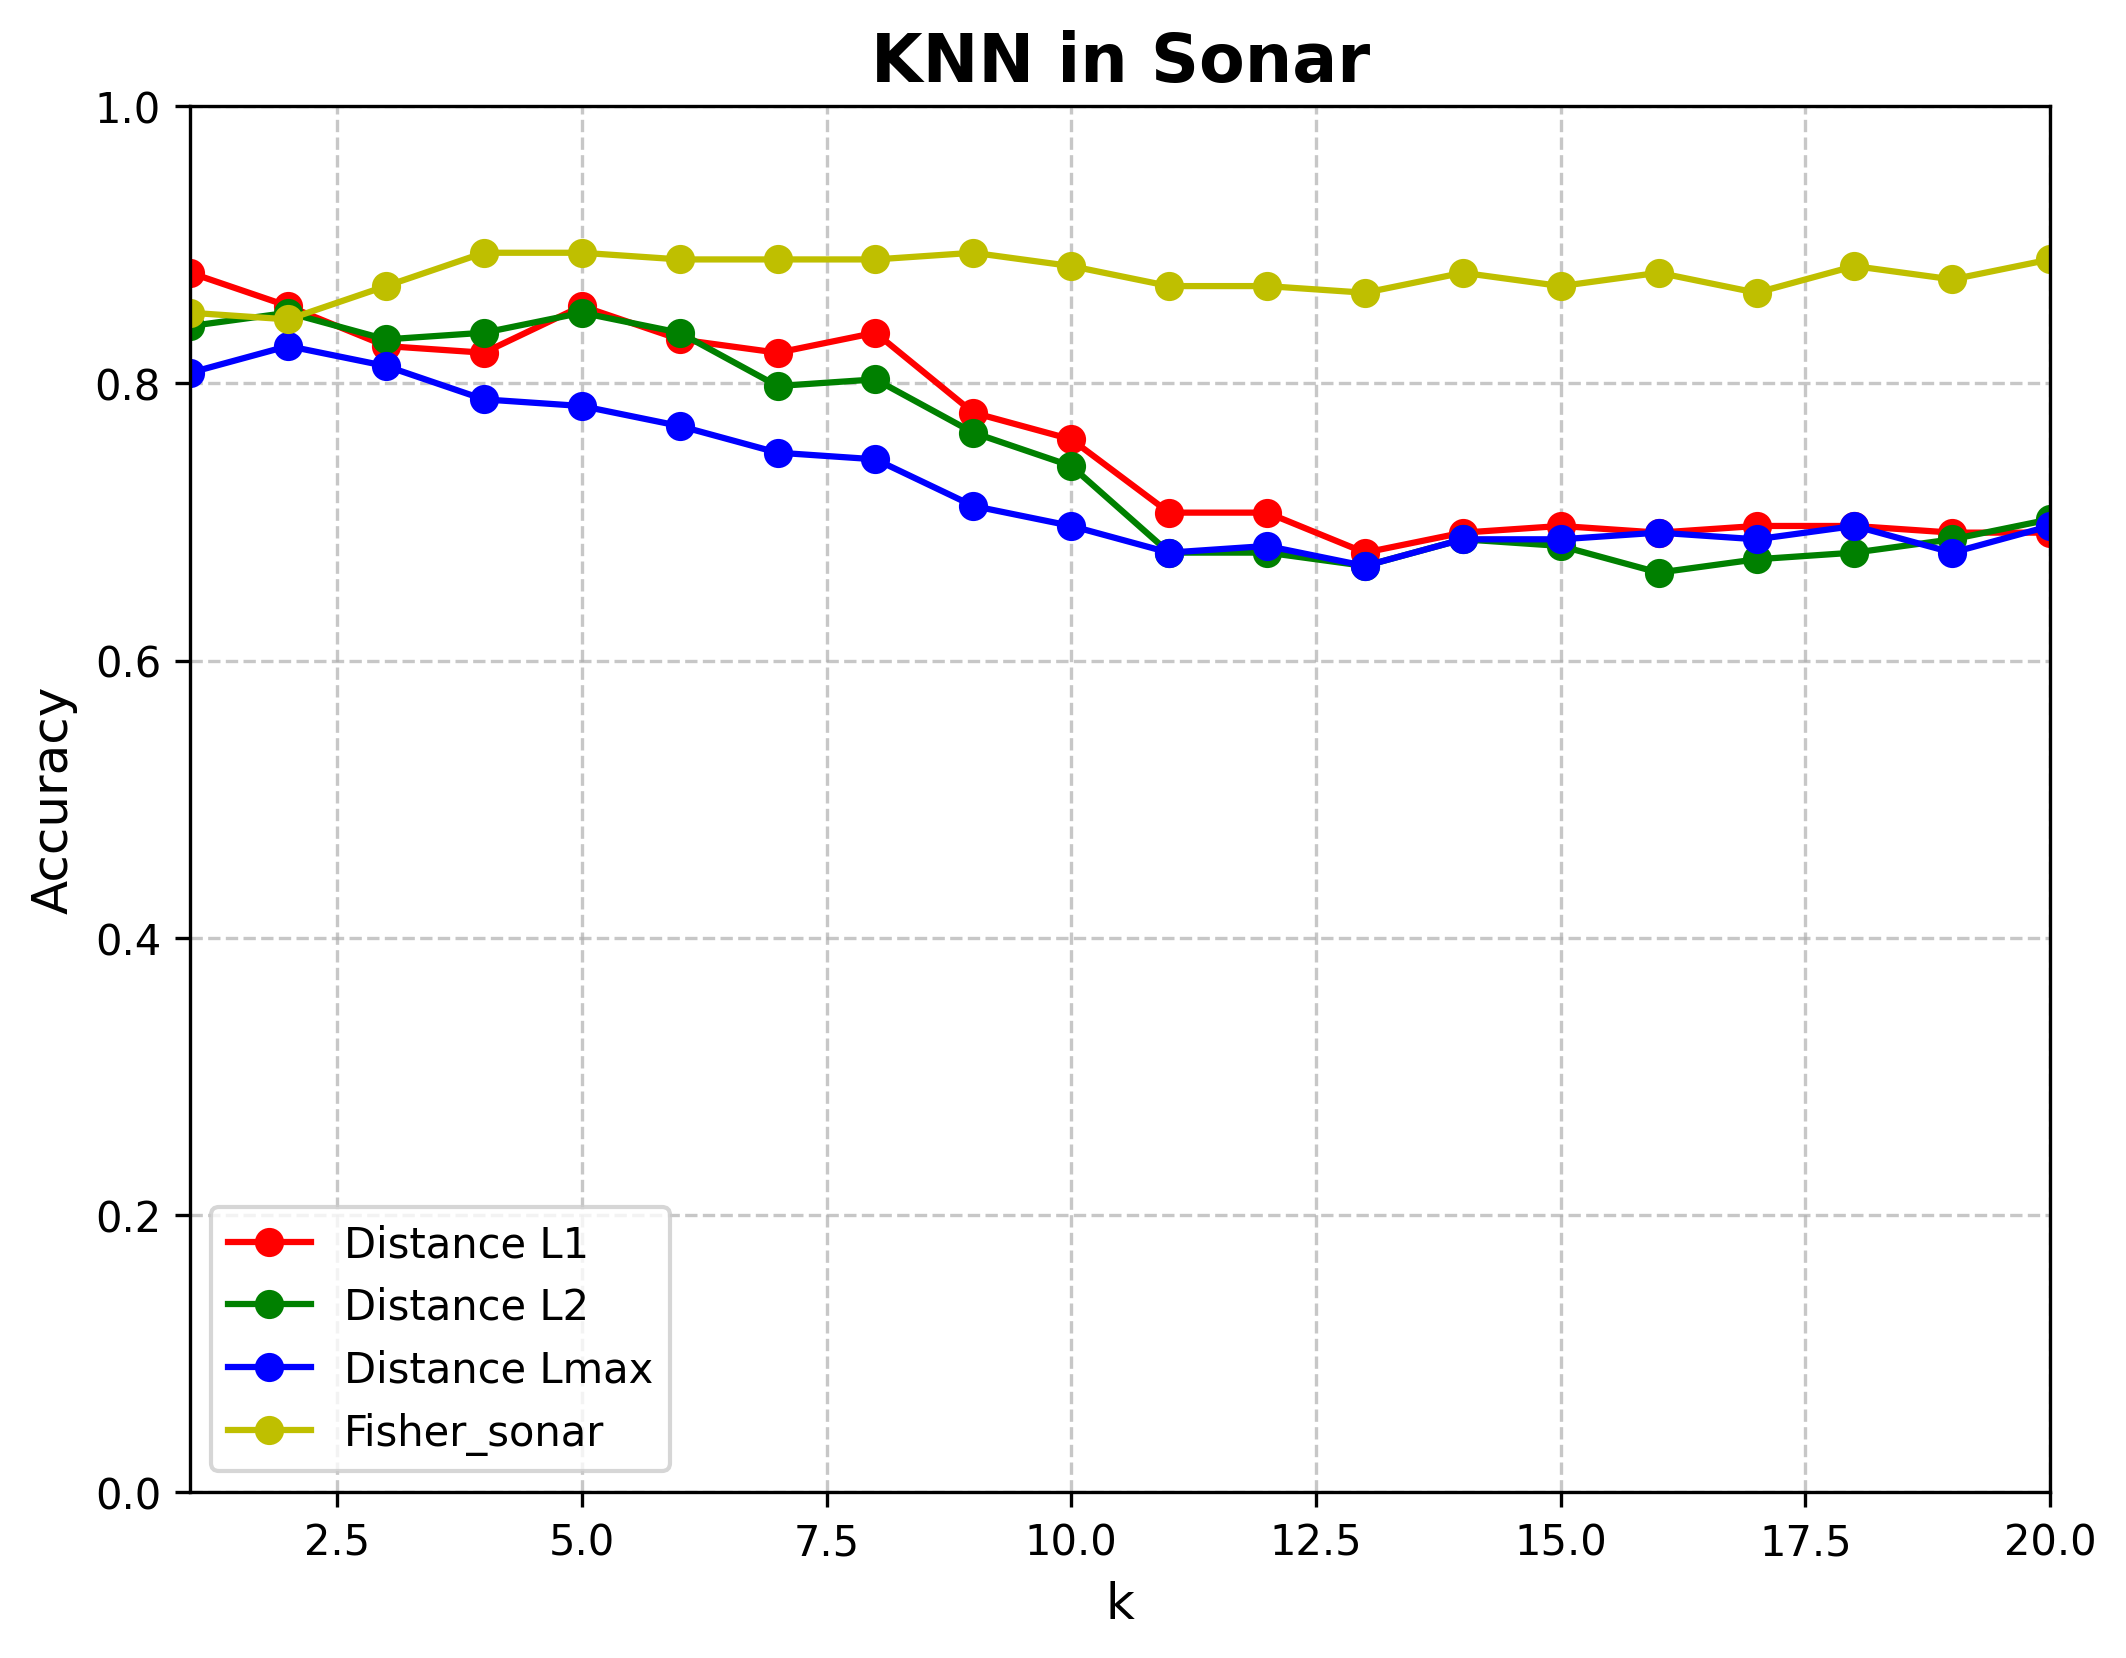

In [90]:
x = np.arange(1,21,1)
# 设置图形参数
plt.figure(figsize=(8, 6), dpi=300)  # 调整图形大小和分辨率
plt.title("KNN in Sonar", fontsize=16, fontweight='bold')  # 设置标题
plt.xlabel('k', fontsize=12)  # 设置x轴标签
plt.ylabel('Accuracy', fontsize=12)  # 设置y轴标签
plt.xticks(fontsize=10)  # 设置x轴刻度文字大小
plt.yticks(fontsize=10)  # 设置y轴刻度文字大小
plt.xlim((1, 20))  # 设置x轴范围
plt.ylim((0, 1.0))  # 设置y轴范围
plt.grid(True, linestyle='--', alpha=0.7)  # 添加网格线

# 绘制曲线
plt.plot(x, accuracy_all[0], 'r-o', label="Distance L1")  # 绘制第一条曲线，红色圆点线条
plt.plot(x, accuracy_all[1], 'g-o', label="Distance L2")  # 绘制第二条曲线，绿色圆点线条
plt.plot(x, accuracy_all[2], 'b-o', label="Distance Lmax")  # 绘制第三条曲线，蓝色圆点线条
plt.plot(x, accuracy_all[3], 'y-o', label="Fisher_sonar")  
# 添加图例
plt.legend(fontsize=10)

# 保存和显示图形
plt.savefig('result_of_KNN_in_Sonar.jpg', dpi=300, bbox_inches='tight')  # 保存图形并设置边界框紧凑
plt.show()